In [1]:
import os
import requests
import zipfile
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad

Download example data and decompress it. They are Cell Painting images of U2OS cells treated with cytochalasin D or mock.

In [2]:

url = "https://zenodo.org/records/18510113/files/zenodo.zip"
output_path = 'zenodo.zip'

response = requests.get(url)
# Raise an exception if the download was unsuccessful
response.raise_for_status() 

# Write the content to a local file in binary mode ('wb')
with open(output_path, 'wb') as f:
    f.write(response.content)


with zipfile.ZipFile("zenodo.zip", 'r') as z:
    z.extractall("zenodo")


Display the first image of the dataset as an example. Also mark the centers of cell objects with red dots.

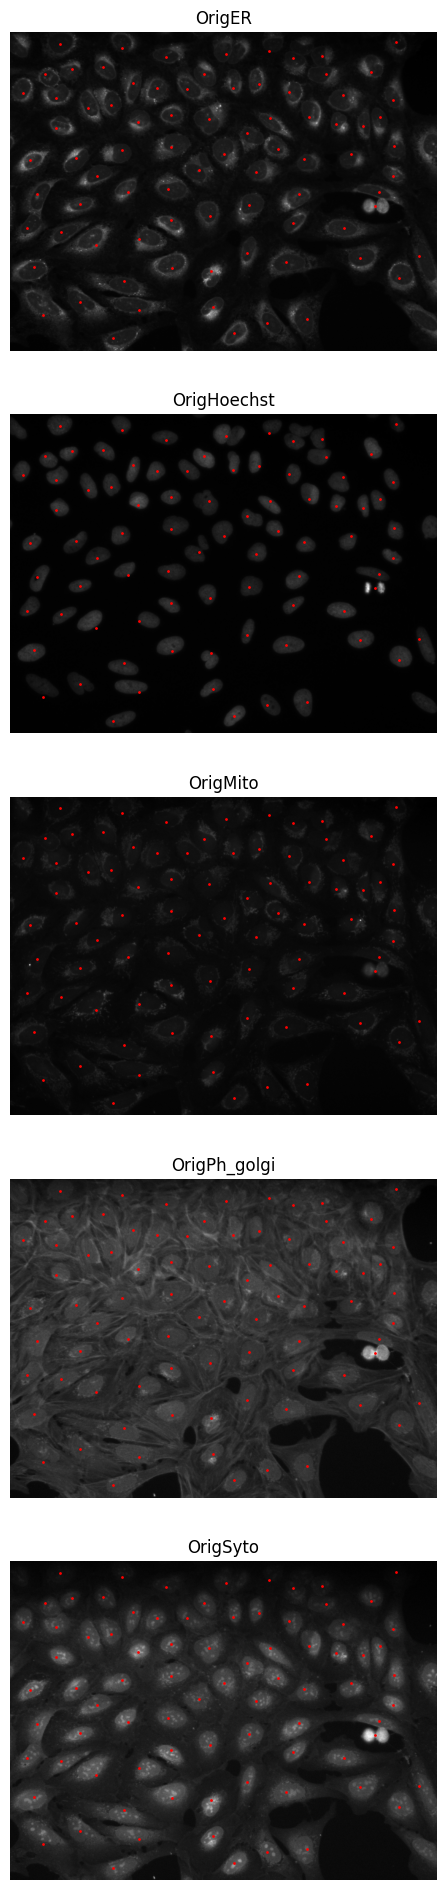

In [3]:
# load cell segmentation by CellProfiler
df = pd.read_csv("zenodo/Cells.csv")

# cell segmentation of image 1
cells_in_img1 = df.query('ImageNumber == 1')

# list the names of channels
channels = [c.replace("Image_FileName_", "") for c in cells_in_img1.columns if c.startswith("Image_FileName_")]

fig, axs = plt.subplots(nrows=len(channels))
fig.set_figheight(24)

# show images of channels
for i, channel in enumerate(channels):
    path_name = cells_in_img1.loc[0, f'PathName_{channel}']
    image_name = cells_in_img1.loc[0, f'Image_FileName_{channel}']
    image_path = f"{path_name}/{image_name}"
    img = Image.open(image_path)
    axs[i].set_title(channel)
    axs[i].imshow(img, cmap='gray', aspect='1')
    axs[i].set_axis_off()
    axs[i].scatter(cells_in_img1['Location_Center_X'], cells_in_img1['Location_Center_Y'],
                   color='red', s=1)

plt.show()


Extract image patches and metadata. Save them to .h5ad file.

In [4]:
os.system("python -m ifcoder.extract --cp-csv zenodo/Cells.csv --out patches.h5ad")

Detected channels: ['OrigER', 'OrigHoechst', 'OrigMito', 'OrigPh_golgi', 'OrigSyto']
Saved AnnData -> patches.h5ad
Cells in CSV        : 601
Cells kept (patches): 537
Cells dropped (edge): 64 (10.6%)
Measurements: 100
Dimensions of patches: (537, 5, 64, 64)


0

Display some patches.

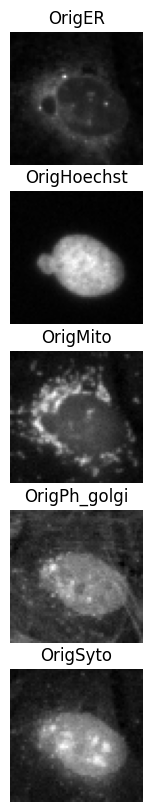

In [5]:
adata1 = ad.read_h5ad("patches.h5ad")
patch_idx = 300
patch_data = adata1.obsm['patches'][patch_idx]

fig, axs = plt.subplots(nrows=len(channels))
fig.set_figheight(10)

# show images of a patch
for i, channel in enumerate(channels):
    img = patch_data[i]
    axs[i].set_title(channel)
    axs[i].imshow(img, cmap='gray', aspect='1')
    axs[i].set_axis_off()

plt.show()

Train VAE on extracted image patches.

In [6]:
os.system("python -m ifcoder.train --data patches.h5ad --out embeddings.h5ad")

epoch 001  loss=0.86054  recon=0.04260  kl=0.81794
epoch 002  loss=0.13669  recon=0.03118  kl=0.10551
epoch 003  loss=0.06144  recon=0.02441  kl=0.03703
epoch 004  loss=0.02315  recon=0.01984  kl=0.00331
epoch 005  loss=0.01755  recon=0.01711  kl=0.00044
epoch 006  loss=0.01580  recon=0.01553  kl=0.00027
epoch 007  loss=0.01468  recon=0.01443  kl=0.00025
epoch 008  loss=0.01367  recon=0.01344  kl=0.00023
epoch 009  loss=0.01302  recon=0.01280  kl=0.00021
epoch 010  loss=0.01264  recon=0.01244  kl=0.00020
Saved embeddings -> embeddings.h5ad  shape=(537, 16)


0

Compute UMAP of cells in the latent space.

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


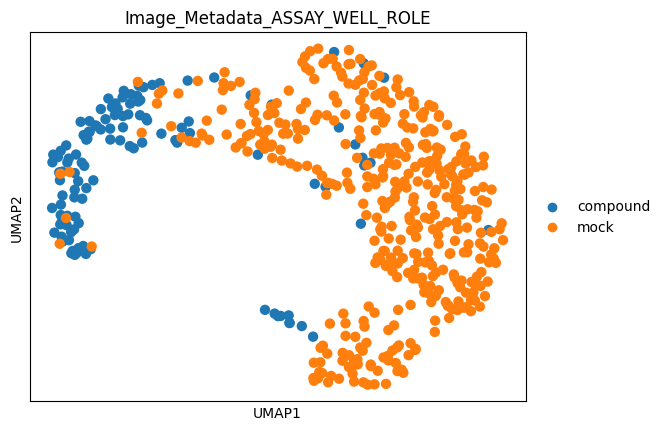

In [7]:
adata = ad.read_h5ad("embeddings.h5ad")
sc.pp.neighbors(adata, use_rep = 'X_ifcoder')
sc.tl.umap(adata)
sc.pl.umap(adata, color='Image_Metadata_ASSAY_WELL_ROLE')